In [1]:
import pandas as pd
import yfinance as yf
import numpy as np

In [2]:
df = yf.download(
    "MSFT",
    start="2012-01-01",
    end="2021-12-31",
    progress=False
)

In [3]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,97.864400,98.764984,96.946363,97.916924,92.005988,3.391675e+07
std,78.092312,78.834571,77.353120,78.156466,77.911155,1.794715e+07
min,26.379999,26.629999,26.260000,26.370001,21.238752,7.425600e+06
25%,41.384999,41.727501,41.047500,41.480000,35.597112,2.282725e+07
50%,62.715000,63.135000,62.324999,62.690001,57.133511,2.963025e+07
75%,134.992504,136.295002,133.572506,135.314999,129.344173,3.954898e+07
max,344.619995,349.670013,342.200012,343.109985,336.315308,2.484285e+08


### Convert prices into returns

By transforming the prices into returns we aim at make the time series stationary. There are two types of returns:

- Simple returns: they aggregate over assets: eg
  $$R_t = \frac{P_t}{P_{t-1}-1}$$
  
- Log returns: they aggregate over time:
  $$r_t = \log\Bigg(\frac{P_t}{P_{t-1}}\Bigg)$$

In general log returns are preferred since, if we assume that the stock-prices are log-normally distributed, then the log returns would be normally distributed.

In [4]:
#df = df[["Close"]]
df = df.loc[:, ["Close"]]
df["simple_rtn"] = df.Close.pct_change()  # percentage change from pandas package
df["log_rtn"] = np.log(df.Close/df.Close.shift(1))
df

,Close,simple_rtn,log_rtn
Date,,,
2012-01-03,26.770000,NaN,NaN
2012-01-04,27.400000,0.023534,0.023261
2012-01-05,27.680000,0.010219,0.010167
2012-01-06,28.110001,0.015535,0.015415
2012-01-09,27.740000,-0.013163,-0.013250
...,...,...,...
2021-12-23,334.690002,0.004472,0.004462
2021-12-27,342.450012,0.023186,0.022921
2021-12-28,341.250000,-0.003504,-0.003510


### Adjusting for inflation

We want to decouple the growth of the stock prices from the inflation. We can do so by using this formula 
$$ R^r_t = \frac{1+R_t}{1+\pi_t}-1$$

where $\pi_t$ is the inflation rate.

In [5]:
# Import the Consumer Price Index from the cpi package and query the correct entries
import cpi 
cpi.update()
cpi_series = cpi.series.get()
df_cpi = cpi_series.to_dataframe()
df_cpi.query("period_type == 'monthly' and year > 2010") \
    .loc[:, ["date", "value"]] \
    .set_index("date") \
    .head(12)


,value
date,
2011-01-01,220.223
2011-02-01,221.309
2011-03-01,223.467
2011-04-01,224.906
2011-05-01,225.964
2011-06-01,225.722
2011-07-01,225.922
2011-08-01,226.545
2011-09-01,226.889


In [6]:
import matplotlib.pyplot as plt

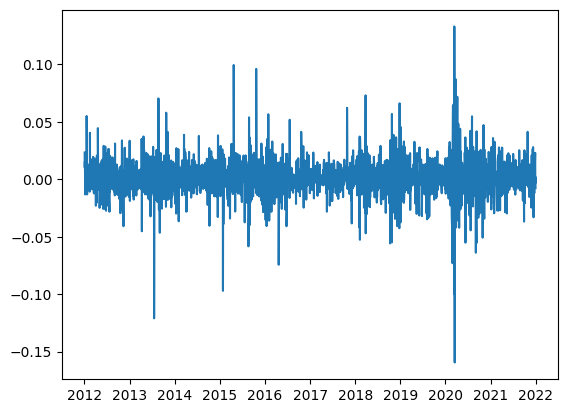

In [7]:
plt.plot(df.log_rtn)

In [8]:
df.dropna(inplace=True)

In [9]:
X = df[["Close", "log_rtn"]]

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df)
df_scaled = scaler.transform(df)
X = df_scaled[:, 0]
y = df_scaled[:, 2]

# Train/test split

In [13]:
split =  int(len(df_scaled) * 0.8)
split

2012

In [14]:
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

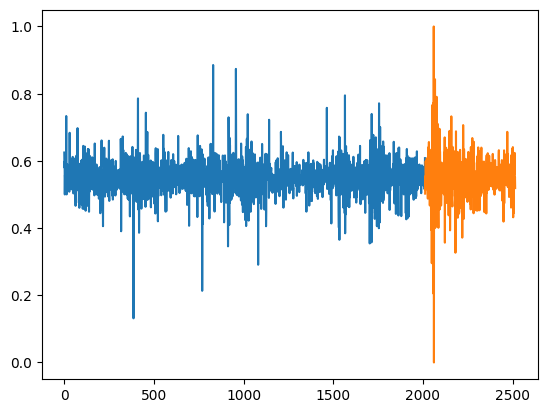

In [15]:
plt.plot(list(range(len(y_train))), y_train)
plt.plot(list(range(len(y_train), len(y_train)+len(y_test))), y_test)

In [16]:
n = 3
print(X_train.shape)
for i in range(n, len(X_train)):
    print(X_train[i-n:i, : X_train.shape[1]])

(2012,)


IndexError: tuple index out of range

In [17]:
bags_of_x = []
bags_of_y = []

for i in range(n, len(X_train)):
    bags_of_x.append(X_train[i-n:i])
    bags_of_y.append(y_train[i])

In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare data
# X_train, X_test, y_train, y_test are already defined from your code

# Reshape the data for LSTM input
X_train = X_train.reshape(-1, 1, 2)  # Reshape to (samples, timesteps, features)
X_test = X_test.reshape(-1, 1, 2)

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(1, 2)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


2024-05-06 16:30:30.465839: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 16:30:30.531002: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 16:30:30.776413: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 16:30:31.651651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ValueError: cannot reshape array of size 503 into shape (1,2)

In [ ]:
!poetry add tensorflow
